# Hidden Markov Model

$
\def\a{\alpha}
\def\g{\gamma}
\def\P{\mathsf{P}}
\def\RR{\mathbb{R}}
\def\idx#1{\hat{#1}}
\def\b{\beta}
\def\range#1#2{\overline{#1:#2}}
\def\L{\mathcal{L}}
\def\E{\mathsf{E}}
\DeclareMathOperator*{\argmax}{arg\,max}
\def\O{\mathcal{O}}
$

## Global settings

### Imports

In [231]:
import math
from random import random, uniform
from itertools import repeat
from itertools import product as cart_prod
from pprint import pprint, pformat
from functools import reduce, partial
import operator
from copy import deepcopy
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

### Plotting

In [232]:
%matplotlib inline
matplotlib.style.use('ggplot')

plt.rcParams['savefig.dpi'] = 72
plt.rcParams['figure.dpi'] = 72
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12  
plt.rcParams['ytick.labelsize'] = 12 
plt.rcParams['legend.fontsize'] = 12 
plt.rcParams['font.family'] = 'serif'  
plt.rcParams['font.serif'] = ['Computer Modern Roman']  
plt.rcParams['text.usetex'] = True 
plt.rcParams['text.latex.unicode'] = True
# plt.rcParams['figure.figsize'] = 5.2, 3.2   # 0.8
# plt.rcParams['figure.figsize'] = 3.9, 2.4   # 0.6
# plt.rcParams['figure.figsize'] = 2.9, 1.8   # 0.45
plt.rcParams['figure.figsize'] = 4.5, 2.8   # 0.7
plt.rcParams['text.latex.preamble'] = r'\usepackage[utf8]{inputenc}'
plt.rcParams['text.latex.preamble'] = r'\usepackage[russian]{babel}'

### Options

In [233]:
# 5: stacktrace
# 6: calculations detailed to terms
# 7: initial data
# TODO: other
VERBOSITY = 6
# as the second argument to round()
OUT_PREC = 3
# for tree-like output
OUT_INCR = '    '

np.set_printoptions(precision=OUT_PREC, suppress=True)

## Auxiliary data structures and functions

In [234]:
class LabeledList(list):
    def __init__(self,  iterable, labels):
        self.labels = labels
        self.idx_dict = {labels[i] : i for i in range(len(labels))}
        super().__init__(iterable)
    def _label_to_idx_proxy(self, method_name, key, *args):
        # allow raw int indices
        if isinstance(key, int):
            idx = key
        else:
            idx = self.idx_dict[key]
        return getattr(super(), method_name)(idx, *args)
    def __getitem__(self, key):
        return self._label_to_idx_proxy('__getitem__', key)
    def __setitem__(self, key, value):
        return self._label_to_idx_proxy('__setitem__', key, value)
    def __sub__(self, ll):
        res = deepcopy(self)
        for i in range(len(ll)):
            res[i] -= ll[i]
        return res
#     def __add__(self, val):
#         if isinstance(val, int):
#             res = sum(self) + val
#         else:
#             res = deepcopy(self)
#             for i in range(len(ll)):
#                 res[i] += ll[i]
#         return res
    def get_sum(self):
        if isinstance(self[0], LabeledList):
            return sum(ll.get_sum() for ll in self)
        else:
            return sum(self)
    def get_abs(self):
        if isinstance(self[0], LabeledList):
            return LabeledList((ll.get_abs() for ll in self), self.labels)
        else:
            return LabeledList((abs(el) for el in self), self.labels)
    def get_max(self):
        if isinstance(self[0], LabeledList):
            return max(ll.get_max() for ll in self)
        else:
            return max(self)
#     def __repr__(self):
#         # ugly
#         return np.array(self).__repr__()[6:-1].replace('      ', '')

### (Tests)

In [235]:
S = 'HL'
Q = 'ACGT'
B = [[0.2, 0.3, 0.3, 0.2],
     [0.3, 0.2, -0.8, 0.4]]

L1 = LabeledList(B[0], Q)
L2 = LabeledList(B[1], Q)
L = LabeledList([L1, L2], S)
print(L['H']['A'])
print(L)
L['H']['A'] = 0.3
print(L['H']['A'])
# print(sum(L1))
# L1 + 2
print(L1.get_sum())
print(L.get_sum())
print(L1-L2)
print(L1)
print(L-L)
print((L1-L2).get_abs())
print(L.get_abs())
print(L.get_abs().get_max())

0.2
[[0.2, 0.3, 0.3, 0.2], [0.3, 0.2, -0.8, 0.4]]
0.3
1.0999999999999999
1.1999999999999997
[0.0, 0.09999999999999998, 1.1, -0.2]
[0.3, 0.3, 0.3, 0.2]
[[0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0]]
[0.0, 0.09999999999999998, 1.1, 0.2]
[[0.3, 0.3, 0.3, 0.2], [0.3, 0.2, 0.8, 0.4]]
0.8


In [236]:
def create_dataframe(M, labels_row, labels_col, op = lambda x: x):
    return LabeledList([LabeledList(map(op, row), labels_col) for row in M],
                       labels_row)

# prod = partial(reduce, lambda x, y: x * y)
def prod(seq):
    return reduce(lambda x, y: x * y, seq, 1)

def dbg(msg, verbosity=5, pp=False, **kwargs):
    if verbosity <= VERBOSITY:
        print_func = pprint if pp else print
        print_func(msg, **kwargs)
        
def verbose_sum(X, out_offset=''):
    result = sum(X)
    if VERBOSITY >= 6:
        print(out_offset + ' + '.join(str(round(x, OUT_PREC)) for x in X) + ' = ' + str(round(result, OUT_PREC)))
    return result

## Initialization

In [237]:
class HMM(object):
    pass

### Initialize a noisy stochastic vector
Let $$v:=c\cdot\left(\frac{1}{n}+\alpha_{i}\right)_{i=0}^{n-1}.$$
  Then $$\sum_{i=0}^{n-1}v_{i}=1\iff\sum_{i=0}^{n-1}c\cdot\left(\frac{1}{n}+\alpha_{i}\right)=1$$
  holds iff $$c=\frac{1}{\sum_{i=0}^{n-1}\left(1/n+\alpha_{i}\right)}=\frac{1}{1+\sum_{i=0}^{n-1}\alpha_{i}}$$
 

In [238]:
def create_stochastic_vector(n, noise=2):
    base = 1. / n
    eps = 1. / n**noise
    noise = [uniform(-eps, eps) for _ in range(n)]
    norm_fact = 1 / (1 + sum(noise))
    return [(base + noise[i]) * norm_fact for i in range(n)]

def create_stochastic_matrix(m, n, noise=2):
    return [create_stochastic_vector(n) for _ in range(m)]

### (Tests)

In [239]:
v = create_stochastic_vector(10, noise=1)
pprint(v)
print(sum(v))

M = create_stochastic_matrix(2, 3)
M

[0.16878103390931656,
 0.1747664608633351,
 0.02093240945028239,
 0.01050294990230636,
 0.1344585658008367,
 0.1612928477787954,
 0.08789231492921762,
 0.03251492171261746,
 0.09328993737775981,
 0.11556855827553252]
0.9999999999999999


[[0.35038006168261004, 0.34538949741320185, 0.304230440904188],
 [0.3556127127439395, 0.3293390745058375, 0.31504821275022304]]

In [240]:
def __init__(self,
        S: "hidden state labels",
        Q: "observation labels",
        priors: r'P(\xi_0 = s_i)' = None,
        A: r'P(\xi_t = s_j | \xi_{t-1} = s_i) state transition matrix' = None,
        B: r'P(\eta_t = q_k | \xi_t = s_i) observation matrix' = None,
        noise = 2):
    """Initialize HMM.

    If any of the priors vector, A or B matrices aren't provided,
    they are initialized with a suitable row-stochastic vector / matrix.
    """
    
    self.S = S
    self.Q = Q

    if not priors:
        priors = create_stochastic_vector(len(S), noise=noise)
    self.priors = LabeledList(priors, S)
    
    if not A:
        A = create_stochastic_matrix(len(S), len(S), noise=noise)
    self.A = create_dataframe(A, S, S)
    
    if not B:
        B = create_stochastic_matrix(len(S), len(Q), noise=noise)
    self.B = create_dataframe(B, S, Q)
    
    self.create_log_matrices()

def __repr__(self):
    return reduce(lambda x, y: x + '\n' + y,
                  (pformat(obj) for obj in [self.priors, self.A, self.B]))

def init_mem(self, name, t, dim=1, init_val=0):
    create_ll = lambda elem, labels: LabeledList([deepcopy(elem) for _ in range(len(self.S))], labels)
    self.mem[name] = [reduce(create_ll, [self.S] * dim, init_val)
                      for _ in range(t)]
        
    
def create_log_matrices(self):
    # to be used in viterbi
    log2_safe = lambda x: math.log2(x) if x != 0 else float('-inf')
    self.priors_log = LabeledList(map(log2_safe, self.priors), self.S)
    self.A_log = create_dataframe(self.A, self.S, self.S, log2_safe)
    self.B_log = create_dataframe(self.B, self.S, self.Q, log2_safe)

HMM.__init__ = __init__
HMM.__repr__ = __repr__
HMM.init_mem = init_mem
HMM.mem = {}
HMM.create_log_matrices = create_log_matrices

### (Tests)

In [241]:
S = 'HL'
Q = 'ACGT'

priors = [0.5, 0.5]
A = [[0.5, 0.5],
     [0.4, 0.6]]
B = [[0.2, 0.3, 0.3, 0.2],
     [0.0, 0.2, 0.0, 0.8]]

hmm = HMM(S, Q, priors, A, B)
print(hmm)
print()
print(hmm.priors_log)
print(hmm.B_log)
print()
hmm = HMM(S, Q)
print(hmm)
print()

hmm.init_mem('alpha', 10)
print(hmm.mem['alpha'])

hmm.init_mem('gamma', 10, dim=2)
pprint(hmm.mem['gamma'])
hmm.mem['gamma'][0][0][0] = 1
hmm.mem['gamma'][0][0][1] = 2
pprint(hmm.mem['gamma'])

[0.5, 0.5]
[[0.5, 0.5], [0.4, 0.6]]
[[0.2, 0.3, 0.3, 0.2], [0.0, 0.2, 0.0, 0.8]]

[-1.0, -1.0]
[[-2.321928094887362, -1.736965594166206, -1.736965594166206, -2.321928094887362], [-inf, -2.321928094887362, -inf, -0.3219280948873623]]

[0.49442568937587383, 0.5055743106241262]
[[0.44290601991542944, 0.5570939800845706],
 [0.5333224360642796, 0.4666775639357202]]
[[0.20330900000014282,
  0.20738837385636763,
  0.3053084442463425,
  0.2839941818971472],
 [0.29888006158001634,
  0.20093286730355267,
  0.20049425427789622,
  0.2996928168385347]]

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0]]
[[[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]]]
[[[1, 2], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [0, 0]],
 [[0, 0], [

## Observation probabilities

For a given observation sequence $Y$, find its probability $\P(Y)$.

### Naive approach

$$\begin{eqnarray*}
\P(Y) & = & \P\left(\bigvee_{X}\left(X\cap Y\right)\right)=\sum_{X}\P(XY)=\sum_{X}\left(\P(Y\mid X)\cdot\P(X)\right)\\
 & = & \sum_{X}\left(\P(Y_{0}\mid X_{0})\P(X_{0})\prod_{t=1}^{T-1}\P(Y_{t}\mid X_{t})\P(X_{t}\mid X_{t-1})\right).
\end{eqnarray*}$$

Complexity: $\O(2TN^T)$    

In [242]:
def pr_YX(self, Y, X):
    return self.B[X[0]][Y[0]] * self.priors[X[0]] * \
            prod(self.B[X[t]][Y[t]] * self.A[X[t-1]][X[t]]
                 for t in range(1, len(Y)))

def pr_Y_naive(self, Y):
    return sum(self.pr_YX(Y, X)
       for X in cart_prod(self.S, repeat=len(Y)))

HMM.pr_YX = pr_YX
HMM.pr_Y_naive = pr_Y_naive

### Example due to Stamp (2012)

In [243]:
S = ['H', 'C']          # Annual temperatures: hot, cold
Q = ['S', 'M', 'L']     # Size of tree growth rings: small, medium, large
priors = [0.6, 0.4]
A = [[0.7, 0.3],
     [0.4, 0.6],]
B = [[0.1, 0.4, 0.5],
     [0.7, 0.2, 0.1],]

hmm_stamp = HMM(S, Q, priors, A, B)

In [244]:
Y = ('S', 'M', 'S', 'L')
list(cart_prod(S, repeat=len(Y)))

[('H', 'H', 'H', 'H'),
 ('H', 'H', 'H', 'C'),
 ('H', 'H', 'C', 'H'),
 ('H', 'H', 'C', 'C'),
 ('H', 'C', 'H', 'H'),
 ('H', 'C', 'H', 'C'),
 ('H', 'C', 'C', 'H'),
 ('H', 'C', 'C', 'C'),
 ('C', 'H', 'H', 'H'),
 ('C', 'H', 'H', 'C'),
 ('C', 'H', 'C', 'H'),
 ('C', 'H', 'C', 'C'),
 ('C', 'C', 'H', 'H'),
 ('C', 'C', 'H', 'C'),
 ('C', 'C', 'C', 'H'),
 ('C', 'C', 'C', 'C')]

In [246]:
print(hmm_stamp.pr_Y_naive(Y))

0.009629599999999999


### Forward algorithm

$$\P(Y)=\sum_{s\in S}\a_{T-1}(s)$$ where $$\begin{eqnarray*}
\a_{t}(s) & = & \P(Y_{0}\ldots Y_{t},\xi_{t}=s)\\
 & = & B_{\idx s\idx y_{t}}\sum_{r\in S}A_{\idx r\idx s}\a_{t-1}(r),\quad t\in\range 1{T-1}\\
\a_{0}(s) & = & B_{\idx s\idx y_{0}}\pi_{\idx s}.
\end{eqnarray*}$$

Complexity: $\O(N^2T)$

If `with_scaling`, also compute $\mathbf{c}=c_0,\dots,c_{T-1},$ where $$c_{t}:=\frac{1}{\sum_{r\in S}\tilde{\a}_{t}(r)},$$ and scale every $\a_t$ as \begin{eqnarray*}
\bar{\a}_{t}(s) & := & \tilde{\a}_{t}(s)\cdot c_{t}\\
\tilde{\a}_{t}(s) & := & B_{\idx s\idx y_{t}}\sum_{r\in S}A_{\idx r\idx s}\bar{\a}_{t-1}(r)
\end{eqnarray*}

In [247]:
def alpha(self, Y, with_scaling=False):
    self.init_mem('alpha', len(Y))
    a = self.mem['alpha']
    if with_scaling:
        self.mem['c'] = [0] * len(Y)
        c = self.mem['c']
    # Compute \alpha_0 (s) \forall s \in S
    for s in self.S:
        a[0][s] = self.priors[s] * self.B[s][Y[0]]
        if with_scaling:
            c[0] += a[0][s]
    # Scale alpha_0
    if with_scaling:
        c[0] = 1 / c[0]
        for s in self.S:
            a[0][s] *= c[0]
    # Compute \alpha_t(s) \forall s \in S
    for t in range(1, len(Y)):
        for s in self.S:
            for r in self.S:
                a[t][s] += self.A[r][s] * a[t-1][r]
            a[t][s] *= self.B[s][Y[t]]
            if with_scaling:
                c[t] += a[t][s]
        # Scale \alpha_t
        if with_scaling:
            c[t] = 1 / c[t]
            for s in self.S:
                a[t][s] *= c[t]

HMM.alpha = alpha

In [248]:
def pr_Y_forward(self, Y, with_scaling=False):
    self.alpha(Y, with_scaling)
    return sum(self.mem['alpha'][-1])

HMM.pr_Y_forward = pr_Y_forward

In [249]:
def pr_Y(self, Y, algorithm='forward', with_scaling=False):
    if algorithm == 'naive':
        return self.pr_Y_naive(Y)
    elif algorithm == 'forward':
        return self.pr_Y_forward(Y, with_scaling)

HMM.pr_Y = pr_Y

In [250]:
print(hmm_stamp.pr_Y_forward(Y))

0.009629599999999997


In [251]:
Y = ('S', 'M', 'S', 'L')
print(hmm_stamp.mem)
print(hmm_stamp.mem['alpha'][0]['H'])

{'alpha': [[0.06, 0.27999999999999997], [0.06159999999999999, 0.0372], [0.0058, 0.02855999999999999], [0.007741999999999998, 0.0018875999999999995]], 'gamma': [[[1, 2], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]}
0.06


In [252]:
Y = ('M')
hmm_stamp.alpha(Y)
print(hmm_stamp.mem)

{'alpha': [[0.24, 0.08000000000000002]], 'gamma': [[[1, 2], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]], [[0, 0], [0, 0]]]}


In [253]:
Y = ('S', 'M', 'S', 'L') 
print(hmm_stamp.pr_Y(Y, 'forward'))
print(hmm_stamp.pr_Y(Y, 'naive'))

Y = ('S') 
print(hmm_stamp.pr_Y(Y, 'forward'))
print(hmm_stamp.pr_Y(Y, 'naive'))

0.009629599999999997
0.009629599999999999
0.33999999999999997
0.33999999999999997


In [254]:
print("Initialized this HMM: ")
print(hmm_stamp)
print()

for algorithm in ('naive', 'forward'):
    print('Observation probabilities using %s algorithm' % algorithm)
    total_pr = 0
    max_prob = 0
    winner = []
    for Y in cart_prod(Q, repeat=3):
        p = hmm_stamp.pr_Y(Y, algorithm=algorithm)
        if p > max_prob:
            max_prob = p
            winner = Y
        print('%s: %s' % (Y, p))
        total_pr += p

    print("Total probability: %f" % total_pr)
    print("Winner: ", end='')
    print(winner)
    print()

Initialized this HMM: 
[0.6, 0.4]
[[0.7, 0.3], [0.4, 0.6]]
[[0.1, 0.4, 0.5], [0.7, 0.2, 0.1]]

Observation probabilities using naive algorithm
('S', 'S', 'S'): 0.06420399999999998
('S', 'S', 'M'): 0.04169199999999999
('S', 'S', 'L'): 0.039703999999999996
('S', 'M', 'S'): 0.034359999999999995
('S', 'M', 'M'): 0.03136
('S', 'M', 'L'): 0.03308
('S', 'L', 'S'): 0.030115999999999997
('S', 'L', 'M'): 0.03138799999999999
('S', 'L', 'L'): 0.034096
('M', 'S', 'S'): 0.044239999999999995
('M', 'S', 'M'): 0.030320000000000003
('M', 'S', 'L'): 0.029439999999999997
('M', 'M', 'S'): 0.03343999999999999
('M', 'M', 'M'): 0.03392
('M', 'M', 'L'): 0.03664
('M', 'L', 'S'): 0.033519999999999994
('M', 'L', 'M'): 0.03736
('M', 'L', 'L'): 0.041120000000000004
('L', 'S', 'S'): 0.043036
('L', 'S', 'M'): 0.030027999999999996
('L', 'S', 'L'): 0.029336
('L', 'M', 'S'): 0.035799999999999985
('L', 'M', 'M'): 0.03712
('L', 'M', 'L'): 0.040279999999999996
('L', 'L', 'S'): 0.03688399999999999
('L', 'L', 'M'): 0.0416119

## Uncovering hidden states

For a given observation sequence $Y$, find its corresponding hidden states $X^*$ so that $$\argmax_X \P(X\mid Y) = X^*$$

### Brute force

Compute $\P(XY)$ over all possible state sequencies $X$ given $Y$.  Choose $X$ as the winner such that it maximizes $\P(XY)$.

In [255]:
def compute_total_prob_table(self, Y):
    prob_table = {}
    for X in cart_prod(self.S, repeat=len(Y)):
        prob_table[''.join(X)] = self.pr_YX(Y, X)
    # exactly pr_Y(Y)
    norm_factor = sum(prob_table.values())
    for key in prob_table:
        prob_table[key] = (prob_table[key], prob_table[key] / norm_factor)
    dbg('Prob. table:')
    dbg(prob_table, pp=True)
    return prob_table

def uncover_bruteforce(self, Y):
    prob_table = self.compute_total_prob_table(Y)
    fmt = ' %%%ss | %%8s | %%10s ' % len(Y)
    print(fmt % ('X', 'P(XY)', 'P(XY)/P(Y)'))
    for X, prob in sorted(prob_table.items(), key=lambda item: item[0]):
            print(" %s | %f | %f " % (X, prob[0], prob[1]))
    opt_X, max_prob = max(prob_table.items(), key=lambda item: item[1][1])
    max_prob = max_prob[1]
    return (opt_X, max_prob)

HMM.compute_total_prob_table = compute_total_prob_table
HMM.uncover_bruteforce = uncover_bruteforce

In [256]:
Y = ('S', 'M', 'S', 'L')
hmm_stamp.uncover_bruteforce(Y)

Prob. table:
{'CCCC': (0.0008467199999999997, 0.08792888593503363),
 'CCCH': (0.002822399999999999, 0.2930962864501121),
 'CCHC': (4.032e-05, 0.004187089806430174),
 'CCHH': (0.0004704, 0.0488493810750187),
 'CHCC': (0.00056448, 0.058619257290022445),
 'CHCH': (0.0018816000000000002, 0.19539752430007482),
 'CHHC': (9.408e-05, 0.009769876215003739),
 'CHHH': (0.0010976, 0.11398188917504364),
 'HCCC': (9.071999999999997e-05, 0.00942095206446789),
 'HCCH': (0.0003023999999999999, 0.0314031735482263),
 'HCHC': (4.32e-06, 0.00044861676497466157),
 'HCHH': (5.04e-05, 0.005233862258037718),
 'HHCC': (0.00021167999999999995, 0.02198222148375841),
 'HHCH': (0.0007055999999999999, 0.07327407161252804),
 'HHHC': (3.5279999999999994e-05, 0.003663703580626402),
 'HHHH': (0.00041159999999999987, 0.04274320844064135)}
    X |    P(XY) | P(XY)/P(Y) 
 CCCC | 0.000847 | 0.087929 
 CCCH | 0.002822 | 0.293096 
 CCHC | 0.000040 | 0.004187 
 CCHH | 0.000470 | 0.048849 
 CHCC | 0.000564 | 0.058619 
 CHCH | 0

('CCCH', 0.2930962864501121)

### Forward-backward demo

At each step t, choose $x_{t}^{*}\in S$ such that $$x_{t}^{*}=\argmax_{X:\xi_{t}=x_{t}^{*}}\P(XY)$$
 

In [257]:
def uncover_fb_demo(self, Y):
    prob_table = self.compute_total_prob_table(Y)
    max_prob_states = [0] * len(Y)
    print('Sum of probabilities of the sequences:')
    for t in range(len(Y)):
        max_prob = 0
        for s in self.S:
            prob = sum(pr[0] for (X, pr) in prob_table.items() if X[t] == s)
            print("%s: %f" % (t * '*' + s + (len(Y)-t-1) * '*', prob))
            if prob > max_prob:
                max_prob = prob
                max_prob_states[t] = s
        print('Max (t = %d): %s' % (t, max_prob_states[t]))
    opt_X = ''.join(max_prob_states)
    max_prob = prob_table[opt_X][1]
    return (opt_X, max_prob)

HMM.uncover_fb_demo = uncover_fb_demo

In [258]:
hmm_stamp.uncover_fb_demo(Y)

Prob. table:
{'CCCC': (0.0008467199999999997, 0.08792888593503363),
 'CCCH': (0.002822399999999999, 0.2930962864501121),
 'CCHC': (4.032e-05, 0.004187089806430174),
 'CCHH': (0.0004704, 0.0488493810750187),
 'CHCC': (0.00056448, 0.058619257290022445),
 'CHCH': (0.0018816000000000002, 0.19539752430007482),
 'CHHC': (9.408e-05, 0.009769876215003739),
 'CHHH': (0.0010976, 0.11398188917504364),
 'HCCC': (9.071999999999997e-05, 0.00942095206446789),
 'HCCH': (0.0003023999999999999, 0.0314031735482263),
 'HCHC': (4.32e-06, 0.00044861676497466157),
 'HCHH': (5.04e-05, 0.005233862258037718),
 'HHCC': (0.00021167999999999995, 0.02198222148375841),
 'HHCH': (0.0007055999999999999, 0.07327407161252804),
 'HHHC': (3.5279999999999994e-05, 0.003663703580626402),
 'HHHH': (0.00041159999999999987, 0.04274320844064135)}
Sum of probabilities of the sequences:
H***: 0.001812
C***: 0.007818
Max (t = 0): C
*H**: 0.005002
*C**: 0.004628
Max (t = 1): H
**H*: 0.002204
**C*: 0.007426
Max (t = 2): C
***H: 0.007

('CHCH', 0.19539752430007482)

### Forward-backward

Let $$\g_{t}(s)=\P\left(\xi_{t}=s\mid Y\right)=\frac{\P(\xi_{t}=s,Y)}{\P(Y)}=\frac{\a_{t}(s)\b_{t}(s)}{\P(Y)}$$ where $\b_{t}(s)=\P(Y_{t+1}\cdots Y_{T-1}\mid\xi_{t}=s)$ and is computed as
$$\begin{eqnarray*}
\b_{t}(s) & = & \sum_{r\in S}\b_{t+1}(r)B_{\idx r\idx y_{t+1}}A_{\idx s\idx r},\quad\forall t\in\range 0{T-2}\\
\b_{T-1}(s) & = & 1.
\end{eqnarray*}$$

Then choose $X^*$ such that $$X^{*}=(x_{0},\ldots,x_{T-1}:x_{t}=\argmax_{s\in S}\gamma_{t}(s),\quad t\in\range 0{T-1}).$$
 


In [259]:
def beta(self, Y, scale=False):
    self.init_mem('beta', len(Y));
    b = self.mem['beta']
    if scale:
        c = self.mem['c']
    for s in self.S:
        b[len(Y)-1][s] = 1 if not scale else c[len(Y)-1]
    for t in reversed(range(len(Y)-1)):
        for s in self.S:
            for r in self.S:
                b[t][s] += self.A[s][r] * self.B[r][Y[t+1]] * b[t+1][r]
#             b[t][s] = sum(b[t+1][r] * self.B[r][Y[t+1]] * self.A[s][r]
#                           for r in self.S)
            if scale:
                b[t][s] *= c[t]

HMM.beta = beta

In [260]:
hmm_stamp.beta(Y)
print(hmm_stamp.mem['beta'])

[[0.030199999999999998, 0.02792], [0.0812, 0.12440000000000001], [0.38, 0.26], [1, 1]]


In [261]:
def gamma(self, Y):
    self.init_mem('gamma', len(Y))
    self.alpha(Y)
    self.beta(Y)
    pr_Y = sum(self.mem['alpha'][-1])
    for t in range(len(Y)):
        for s in self.S:
            self.mem['gamma'][t][s] = self.mem['alpha'][t][s] * self.mem['beta'][t][s] / pr_Y
            
HMM.gamma = gamma

In [262]:
hmm_stamp.gamma(Y)
print(hmm_stamp.mem['gamma'])

[[0.1881698097532608, 0.8118301902467394], [0.5194317520976989, 0.4805682479023014], [0.2288776273157764, 0.7711223726842237], [0.8039793968596827, 0.19602060314031736]]


In [263]:
def backtrack(self, mem):
    dbg('Backtracking:')
    path = [None] * len(mem)
    for t, step in enumerate(mem):
        dbg('t = %s' % t)
        max_state_prob = -float('inf')
        for i, state_prob in enumerate(step):
            dbg('%s: %s' % (self.S[i], state_prob))
            if state_prob > max_state_prob:
                max_state_prob = state_prob
                path[t] = self.S[i]
    return path

HMM.backtrack = backtrack

In [264]:
def uncover_forward_backward(self, Y):
    self.gamma(Y)
    path = self.backtrack(self.mem['gamma'])
    opt_X = ''.join(path)
    max_prob = self.pr_YX(Y, opt_X)
    return (opt_X, max_prob)

HMM.uncover_forward_backward = uncover_forward_backward

In [265]:
hmm_stamp.uncover_forward_backward(Y)

Backtracking:
t = 0
H: 0.1881698097532608
C: 0.8118301902467394
t = 1
H: 0.5194317520976989
C: 0.4805682479023014
t = 2
H: 0.2288776273157764
C: 0.7711223726842237
t = 3
H: 0.8039793968596827
C: 0.19602060314031736


('CHCH', 0.0018816000000000002)

In [266]:
0.0018816 / hmm_stamp.pr_Y(Y)

0.19539752430007484

### Viterbi alogirthm
Find $$\argmax_{X}\P(X\mid Y)=(x_{0},\ldots,x_{T-1}:x_{t}=\argmax_{s\in S}f_{t}(s),\quad t\in\range 0{T-1})$$ where
$$\begin{eqnarray*}
f_{t}(s) & = & \max_{x_{0},\ldots,x_{t-1}\in S}\P(X_{0}\ldots X_{t-1},\xi_{t}=s,Y_{0}\ldots Y_{t})\\
 & = & B_{\idx s\idx y_{t}}\max_{r\in S}A_{\idx r\idx s}f_{t-1}(r)\\
f_{0}(s) & = & B_{\idx s\idx y_{0}}\cdot\pi_{\idx s}.
\end{eqnarray*}$$

Avoid vanishing probabilities as $t \to \infty$: compute $$\tilde{f}_{t}(s)=\log f_{t}(s)=\max_{r\in S}\left(\log A_{\idx r\idx s}+\log B_{\idx s\idx y_{t}}+\tilde{f}_{t-1}(r)\right).$$

In [267]:
def viterbi(self, Y, with_log=True, algorithm='iterative'):
    def viterbi_iter(Y, op):
        for s in S:
            mem[0][s] = op(B[s][Y[0]], priors[s])
            dbg('f_%s (%s) = %s' % (0, s, mem[0][s]))
        for t in range(1, len(Y)):
            for s in S:
                mem[t][s] = -float('inf')
                for r in S:
                    cur_val = op(A[r][s], mem[t-1][r])
                    if cur_val > mem[t][s]:
                        mem[t][s] = cur_val
                mem[t][s] = op(mem[t][s], B[s][Y[t]])
                dbg('f_%s (%s) = %s' % (t, s, mem[t][s]))
    
    def viterbi_rec(t, s, op, out_offset=''):
        dbg(out_offset + 'f_%s (%s):' % (t, s))
        if mem[t][s] is not None:
            p = mem[t][s]
        else:
            if t == 0:
                p = op(B[s][Y[t]], priors[s], out_offset=out_offset)
            else:
                p = op(B[s][Y[t]],
                        max(op(A[r][s],
                               viterbi_rec(t-1, r, op, out_offset+OUT_INCR),
                               out_offset=out_offset)
                            for r in S),
                        out_offset=out_offset)
            dbg(out_offset+'Appending state to mem...', 7)
            dbg(out_offset+'%s -> ' % mem, 8, end='')
            mem[t][s] = p
            dbg(out_offset+'%s' % mem, 7)
        dbg(out_offset + '==> f_%s (%s) = %s' % (t, s, round(p, OUT_PREC)), 5)
        return p
    
    if with_log:
        A = self.A_log
        B = self.B_log
        priors = self.priors_log
        op = lambda *args, **kwargs: verbose_sum(args, **kwargs)
    else:
        #TODO: verbose prod
        A = self.A
        B = self.B
        priors = self.priors
        op = lambda *args, **kwargs: reduce(operator.mul, args, 1)
    S = self.S
    self.init_mem('viterbi', len(Y), init_val=None)
    mem = self.mem['viterbi']
    dbg('Using matrices:', 8)
    dbg('A = ', 8)
    dbg(A, 8)
    dbg('B = ', 8)
    dbg(B, 8)
    if algorithm == 'recursive':
        for s in S:
            viterbi_rec(len(Y)-1, s, op, out_offset='')
            print()
    elif algorithm == 'iterative':
        viterbi_iter(Y, op)
    else:
        raise Exception(NotImplemented)
        
    # backtracking
    dbg(mem)
    return self.backtrack(mem)

HMM.viterbi = viterbi

#### Example due to Borodovsky & Ekisheva (2006), pp 80-81

(+ presentation HMM: Viterbi alogirhtm - a toy example)

In [269]:
S = 'HL'
Q = 'ACGT'

priors = [0.5, 0.5]
A = [[0.5, 0.5],
     [0.4, 0.6]]
B = [[0.2, 0.3, 0.3, 0.2],
     [0.3, 0.2, 0.2, 0.3]]

hmm_borod = HMM(S, Q, priors, A, B)

Y = 'GGCACTGAA'
# Y = 'G'

VERBOSITY = 7
print(hmm_borod.viterbi(Y, algorithm='recursive'))

f_8 (H):
    f_7 (H):
        f_6 (H):
            f_5 (H):
                f_4 (H):
                    f_3 (H):
                        f_2 (H):
                            f_1 (H):
                                f_0 (H):
                                -1.737 + -1.0 = -2.737
                                Appending state to mem...
                                [[-2.736965594166206, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]
                                ==> f_0 (H) = -2.737
                            -1.0 + -2.737 = -3.737
                                f_0 (L):
                                -2.322 + -1.0 = -3.322
                                Appending state to mem...
                                [[-2.736965594166206, -3.321928094887362], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]
                                ==> f_0 (L) 

In [270]:
print(hmm_borod.viterbi(Y, algorithm='iterative'))

-1.737 + -1.0 = -2.737
f_0 (H) = -2.736965594166206
-2.322 + -1.0 = -3.322
f_0 (L) = -3.321928094887362
-1.0 + -2.737 = -3.737
-1.322 + -3.322 = -4.644
-3.737 + -1.737 = -5.474
f_1 (H) = -5.473931188332412
-1.0 + -2.737 = -3.737
-0.737 + -3.322 = -4.059
-3.737 + -2.322 = -6.059
f_1 (L) = -6.058893689053568
-1.0 + -5.474 = -6.474
-1.322 + -6.059 = -7.381
-6.474 + -1.737 = -8.211
f_2 (H) = -8.210896782498619
-1.0 + -5.474 = -6.474
-0.737 + -6.059 = -6.796
-6.474 + -2.322 = -8.796
f_2 (L) = -8.795859283219775
-1.0 + -8.211 = -9.211
-1.322 + -8.796 = -10.118
-9.211 + -2.322 = -11.533
f_3 (H) = -11.53282487738598
-1.0 + -8.211 = -9.211
-0.737 + -8.796 = -9.533
-9.211 + -1.737 = -10.948
f_3 (L) = -10.947862376664824
-1.0 + -11.533 = -12.533
-1.322 + -10.948 = -12.27
-12.27 + -1.737 = -14.007
f_4 (H) = -14.006756065718392
-1.0 + -11.533 = -12.533
-0.737 + -10.948 = -11.685
-11.685 + -2.322 = -14.007
f_4 (L) = -14.006756065718392
-1.0 + -14.007 = -15.007
-1.322 + -14.007 = -15.329
-15.007 + -2

In [271]:
# viterbi probabilities not meaningful?
Y = ('S', 'M', 'S', 'L')
hmm_stamp.viterbi(Y, with_log=False, algorithm='iterative')

f_0 (H) = 0.06
f_0 (C) = 0.27999999999999997
f_1 (H) = 0.0448
f_1 (C) = 0.0336
f_2 (H) = 0.003136
f_2 (C) = 0.014111999999999998
f_3 (H) = 0.0028223999999999996
f_3 (C) = 0.0008467199999999998
[[0.06, 0.27999999999999997], [0.0448, 0.0336], [0.003136, 0.014111999999999998], [0.0028223999999999996, 0.0008467199999999998]]
Backtracking:
t = 0
H: 0.06
C: 0.27999999999999997
t = 1
H: 0.0448
C: 0.0336
t = 2
H: 0.003136
C: 0.014111999999999998
t = 3
H: 0.0028223999999999996
C: 0.0008467199999999998


['C', 'H', 'C', 'H']

In [272]:
sum([0.2799999999999999, 0.0448, 0.014111999999999998, 0.0028223999999999996])

0.34173439999999994

In [273]:
def uncover(self, Y, algorithm='viterbi', **kwargs):
    if algorithm == 'bruteforce':
        return self.uncover_bruteforce(Y)
    elif algorithm == 'forward-backward_demo':
        return self.uncover_fb_demo(Y)
    elif algorithm == 'forward-backward':
        return self.uncover_forward_backward(Y)
    elif algorithm == 'viterbi':
        return self.viterbi(Y, kwargs)
    else:
        raise Exception(NotImplemented)

HMM.uncover = uncover

#### Simulation

In [275]:
def simulate(self, n):
    X = [np.random.choice(list(self.S), 1, p=self.priors)[0]]
    Y = [np.random.choice(list(self.Q), 1, p=self.B[0])[0]]
    for _ in range(n - 1):
        X.append(np.random.choice(list(self.S), 1, p=self.A[X[-1]])[0])
        Y.append(np.random.choice(list(self.Q), 1, p=self.B[X[-1]])[0])
    return X, Y

HMM.simulate = simulate

In [276]:
X, Y = hmm_borod.simulate(100)
VERBOSITY = 4
X_est = hmm_borod.viterbi(Y)
print(hmm_borod)
print(sum(np.array(X) == np.array(X_est)) / 100)

[0.5, 0.5]
[[0.5, 0.5], [0.4, 0.6]]
[[0.2, 0.3, 0.3, 0.2], [0.3, 0.2, 0.2, 0.3]]
0.55


In [277]:
S = 'AB'
Q = 'XYZ'

priors = [0.5, 0.5]
A = [[0.85, 0.15],
     [0.12, 0.88]]
B = [[0.8, 0.1, 0.1],
     [0.0, 0.0, 1]]
hmm_reference = HMM(S, Q, priors, A, B)

X, Y = hmm_reference.simulate(1000)
VERBOSITY = 4
X_est = hmm_reference.viterbi(Y)
print(hmm_reference)
print(sum(np.array(X) == np.array(X_est)) / 1000)

[0.5, 0.5]
[[0.85, 0.15], [0.12, 0.88]]
[[0.8, 0.1, 0.1], [0.0, 0.0, 1]]
0.952


In [278]:
X, Y = hmm_stamp.simulate(1000)
VERBOSITY = 4
X_est = hmm_stamp.viterbi(Y)
print(hmm_stamp)
print(sum(np.array(X) == np.array(X_est)) / 1000)

[0.6, 0.4]
[[0.7, 0.3], [0.4, 0.6]]
[[0.1, 0.4, 0.5], [0.7, 0.2, 0.1]]
0.811


In [279]:
# res = []
# T = 1000
# hmm_init_rand22 = HMM('AB', 'CD', noise=1)
# for t in range(100):
#     X, Y = hmm_init_rand22.simulate(T)
#     X_est = hmm_init_rand22.viterbi(Y)
#     res.append(sum(np.array(X) == np.array(X_est)) / T)
# plt.tight_layout(pad=0.1)
# plt.plot(res)
# plt.show()
# print(np.mean(res))

##### Random matrices

[0.4163572963449206, 0.5836427036550794]
[[0.7216486554528719, 0.278351344547128],
 [0.38904108172616525, 0.6109589182738348]]
[[0.25942840112460025,
  0.23236403924574478,
  0.26152596880082885,
  0.24668159082882612],
 [0.2757745189750482,
  0.26892892308281263,
  0.20238019867096765,
  0.2529163592711715]]


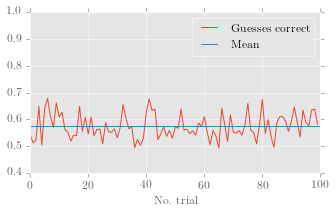

0.57365


In [208]:
plt.rcParams['figure.figsize'] = 4.5, 2.8   # 0.7

VERBOSITY = 4
res = []
T = 1000
for t in range(100):
    hmm_init_rand = HMM('AB', 'CDEF', noise=3)
    X, Y = hmm_init_rand.simulate(T)
    X_est = hmm_init_rand.viterbi(Y)
    res.append(sum(np.array(X) == np.array(X_est)) / T)

print(hmm_init_rand)

# with plt.style.context(('grayscale')):
plt.plot(res, label=r'Guesses correct')
plt.ylim(0.4, 1)
plt.axhline(np.mean(res), label='Mean', color='#348ABD')
plt.legend()
plt.xlabel('No. trial')
plt.tight_layout(pad=0.1)
# plt.ylabel('bar')
plt.savefig('viterbi-2_4.pdf')
plt.show()
print(np.mean(res))

##### Non-random matrix

[0.5, 0.5]
[[0.9, 0.1], [0.05, 0.95]]
[[0.8, 0.1, 0.05, 0.05], [0.0, 0.95, 0.04, 0.01]]


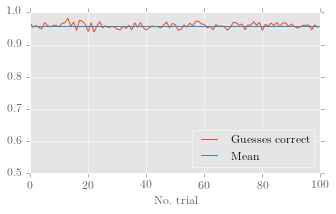

0.95863


In [215]:
res = []
T = 1000
hmm_nonrandom = HMM('AB', 'CDEF', [0.5, 0.5], [[0.9, 0.1], [0.05, 0.95]], [[0.8, 0.1, 0.05, 0.05], [0.0, 0.95, 0.04, 0.01]])
for t in range(100):
#     hmm_init_rand = HMM('AB', 'CDEF', noise=1)
    X, Y = hmm_nonrandom.simulate(T)
    X_est = hmm_nonrandom.viterbi(Y)
    res.append(sum(np.array(X) == np.array(X_est)) / T)
plt.plot(res, label=r'Guesses correct')
plt.ylim(0.5, 1)
plt.axhline(np.mean(res), label='Mean', color='#348ABD')
plt.legend(loc='lower right')
plt.xlabel('No. trial')
plt.tight_layout(pad=0.1)
# plt.ylabel('bar')
plt.savefig('viterbi-2_4-good.pdf')
plt.show()
print(np.mean(res))

## Learning

In [282]:
def baum_welch_scaled_step(self, Y):
    self.init_mem('delta', len(Y)-1, dim=2)
    self.init_mem('gamma', len(Y))
    self.alpha(Y, with_scaling=True)
    self.beta(Y, scale=True)
    a = self.mem['alpha']
    b = self.mem['beta']
    d = self.mem['delta']    # unnormalized
    g = self.mem['gamma']    # unnormalized
    
    dbg('alpha: %s' % a, pp=True)
    dbg('beta: %s' % b, pp=True)
    
    # Calculate \gamma * P(Y) and \delta * P(Y)
    
    for t in range(len(Y)-1):
        # CUT
#         denom = 0
#         for s in self.S:
#             for r in self.S:
#                 denom += self.A[s][r] * self.B[r][Y[t+1]] * a[t][s] * b[t+1][r]
        # CUT
        for s in self.S:
            for r in self.S:
                d[t][s][r] = self.A[s][r] * self.B[r][Y[t+1]] * a[t][s] * b[t+1][r]
#                 d[t][s][r] = self.A[s][r] * self.B[r][Y[t+1]] * a[t][s] * b[t+1][r] / denom
            g[t][s] = sum(d[t][s])
    
    dbg('delta: %s' % d, pp=True)
    
    # Special case of t = T-1
    denom = 0
    for s in self.S:
        g[len(Y)-1][s] = a[len(Y)-1][s] * b[len(Y)-1][s]
        denom += g[len(Y)-1][s]
    for s in self.S:
        g[len(Y)-1][s] /= denom
        
    dbg('gamma: %s' % g, pp=True)
    
    # Re-esitimate priors, A and B
    
    # priors
    for s in self.S:
        self.priors[s] = g[0][s]
        
    dbg('priors: %s' % self.priors, pp=True)
    
    # A
    for s in self.S:
        for r in self.S:
            numer = denom = 0
            for t in range(len(Y)-1):
                numer += d[t][s][r]
                denom += g[t][s]
            self.A[s][r] = numer / denom
    
    dbg('A: %s' % self.A, pp=True)

    # B
    for s in self.S:
        for q in self.Q:
            numer = denom = 0
            for t in range(len(Y)):
                if Y[t] == q:
                    numer += g[t][s]
                denom += g[t][s]
            self.B[s][q] = numer / denom
        
    dbg('B: %s' % self.B, pp=True)

    return sum(math.log(c) for c in self.mem['c'])   # minus

HMM.baum_welch_scaled_step = baum_welch_scaled_step

In [283]:
HMM.baum_welch_step = HMM.baum_welch_scaled_step

In [284]:
S = ['H', 'C']          # Annual temperatures: hot, cold
Q = ['S', 'M', 'L']     # Size of tree growth rings: small, medium, large
priors = [0.6, 0.4]
A = [[0.7, 0.3],
     [0.4, 0.6],]
B = [[0.1, 0.4, 0.5],
     [0.7, 0.2, 0.1],]

hmm_stamp = HMM(S, Q, priors, A, B)

In [285]:
Y = ('S', 'M', 'S', 'L', 'L', 'M', 'M', 'L', 'S')
VERBOSITY = 4
print(math.log(hmm_stamp.pr_Y(Y)))
print(hmm_stamp.baum_welch_step(Y))
# print(hmm_stamp)

-10.133328913140712
10.133328913140712


In [286]:
hmm_stamp = HMM(S, Q, priors, A, B)

In [287]:
def train(self, Y, eps=0, max_iter=float('inf'), metric='P(Y)', graphics=False):
    if metric == 'P(Y)':
        columns = [r'$-\log \mathsf{P}(Y)$']
    elif metric == 'model':
        columns = [r'$\max |\pi^{(t)} - \pi^{(t-1)}|$', r'$\max |A^{(t)} - A^{(t-1)}|$', r'$\max |B^{(t)} - B^{(t-1)}|$']
    hist = pd.DataFrame(None, columns=columns)
    iter_n = 0
    diff = float('inf')    # "statistic"
    P_Y = None
    while ((iter_n < max_iter) and (diff > eps)):
        dbg('iter #%s' % iter_n, 4, end='')
        if metric == 'model':
            priors_old = deepcopy(self.priors)
            A_old = deepcopy(self.A)
            B_old = deepcopy(self.B)
        p_old = self.baum_welch_step(Y)  # return *old* value of P(Y)
        if metric == 'model':
            model_diff = [(self.priors - priors_old).get_abs().get_max(),
                          (self.A - A_old).get_abs().get_max(),
                          (self.B - B_old).get_abs().get_max()]
            hist.loc[len(hist)] = model_diff
            diff = max(model_diff)
        elif metric == 'P(Y)':
            hist.loc[len(hist)] = p_old
            if P_Y is None:
                P_Y = p_old
            else:
                diff = P_Y - p_old
                P_Y = p_old
        else:
            raise NotImplementedError('Unknown metric "%s"' % metric)
        dbg(' %s' % diff, 4)
        iter_n += 1
    self.create_log_matrices()
    return hist

HMM.train = train

In [288]:
# def plot_df(df, filename=None):
#     for col in df:
#         plt.plot(df[col], label=col)
#     plt.legend()
#     plt.tight_layout(pad=0.1)
#     if filename:
#         plt.savefig(filename)
#     plt.show()

### Metrics

iter #0 inf
iter #1 0.7053384534477196
iter #2 0.2366534790217596
iter #3 0.1914880117074116
iter #4 0.2803337394100627
iter #5 0.3356735337824315
iter #6 0.21624843316155662
iter #7 0.09612651617275958
iter #8 0.04639245204273834
iter #9 0.02419850711270044
iter #10 0.012551110028746315
iter #11 0.006418926635613609
iter #12 0.003265754273780175
iter #13 0.001668848144475099
iter #14 0.0008667043461905166
iter #0 0.41133164499919206
iter #1 0.1466570272822425
iter #2 0.09531190856785265
iter #3 0.11519607446536409
iter #4 0.10815225135075723
iter #5 0.04960208798701969
iter #6 0.020249472603113938
iter #7 0.012027159164019896
iter #8 0.006572850945039605
iter #9 0.0034135082972987364
iter #10 0.0017233001631837567
iter #11 0.0012142453061034786
iter #12 0.0009758084273338019
iter #13 0.0008761039875897353
iter #14 0.0009205805609491663


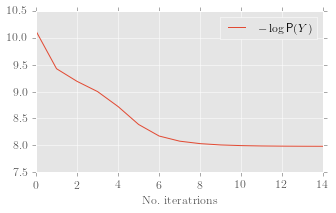

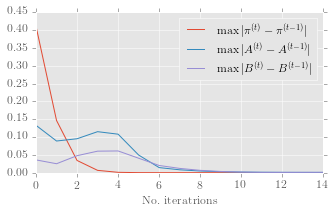

In [154]:
# plt.rcParams['figure.figsize'] = 3.9, 2.4   # 0.6
matplotlib.style.use('ggplot')
Y = ('S', 'M', 'S', 'L', 'L', 'M', 'M', 'L', 'S')
VERBOSITY = 4
hmm_stamp_copy = deepcopy(hmm_stamp)
for n, metric in enumerate(['P(Y)', 'model']):
    hmm_stamp_copy = HMM(S, Q, priors, A, B)
    h = hmm_stamp_copy.train(Y, metric=metric, max_iter=15)
#     plot_df(h, 'metric-%s.pdf' % metric)
#     with plt.style.context(('grayscale')):
#     plt.plot(h)
#     plt.tight_layout(pad=0.1)
#     plt.show()
#     ax = h.plot(figsize=(10, 7), fontsize=16)
#     ax = h.plot(figsize=(plt.rcParams['figure.figsize']))
#     plt.subplot(2, 1, n+1)
#     h.plot(subplots=True)
    ax = h.plot()
#     print(ax)
    ax.legend()
    plt.xlabel('No. iteratrions')
    ax.figure.tight_layout(pad=0.1)
    ax.figure.savefig('metric-%s.pdf' % metric)
#     ax.tick_params(labelsize=16)
#     ax.legend(fontsize=16)
#     ax.figure.dpi = 72
#     ax.figure.savefig('metric-%s.pdf' % metric, dpi=72)

### Simulation

In [155]:
S = 'AB'
Q = 'XYZ'

In [156]:
priors = [0.5, 0.5]
A = [[0.85, 0.15],
     [0.12, 0.88]]
B = [[0.8, 0.1, 0.1],
     [0.0, 0.0, 1]]

In [157]:
hmm_reference_borrowed = HMM(S, Q, priors, A, B)

In [158]:
hmm_reference_rand = HMM(S, Q)

In [159]:
hmm_reference = deepcopy(hmm_stamp)

In [160]:
T = 1000
X, Y = hmm_reference.simulate(T)
print(Y[:20])

['M', 'M', 'L', 'L', 'S', 'S', 'M', 'M', 'L', 'M', 'L', 'S', 'S', 'S', 'M', 'L', 'S', 'M', 'S', 'S']


Expected: 
[0.6, 0.4]
[[0.7, 0.3], [0.4, 0.6]]
[[0.1, 0.4, 0.5], [0.7, 0.2, 0.1]]

Initial: 
[0.5070568611138777, 0.49294313888612223]
[[0.49069498038294745, 0.5093050196170525],
 [0.5033638100548438, 0.49663618994515624]]
[[0.3357496636761467, 0.35319056491427614, 0.3110597714095771],
 [0.3659355778530853, 0.3046356674324046, 0.32942875471451016]]
iter #0 inf
iter #1 1.0798947941186725
iter #2 0.005448421421760941
iter #3 0.0053534547319031844
iter #4 0.00524763506018644
iter #5 0.005131152436206321
iter #6 0.00500418562660343
iter #7 0.004867037340545721
iter #8 0.004720250680975369
iter #9 0.004564690768802393
iter #10 0.004401581925094433
iter #11 0.004232497997918472
iter #12 0.004059310112552339
iter #13 0.003884101556877795
iter #14 0.0037090624803113315
iter #15 0.003536378032549692
iter #16 0.0033681224322208436
iter #17 0.00320616869407786
iter #18 0.003052120395750535
iter #19 0.0029072681179513893
iter #20 0.0027725704101158044
iter #21 0.002648656354040213
iter #22 0.00253

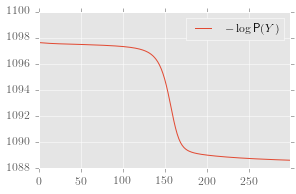

In [162]:
VERBOSITY = 4
print('Expected: ')
print(hmm_reference)
print()
# priors = create_stochastic_vector(len(S))
# A = create_stochastic_matrix(len(S), len(S))
# B = create_stochastic_matrix(len(S), len(Q))
# priors = [0.5, 0.5]
# A = [[0.5, 0.5],
#      [0.5, 0.5]]
# B = [[0.3, 0.3, 0.4],
#      [0.2, 0.5, 0.3]]
# for metric in [('P(Y)', 0.001), ('model', 0.0001)]:
for metric in [('P(Y)', 0.0001)]:
#     hmm_train = HMM(S, Q, priors, A, B)
    hmm_train = HMM(hmm_reference.S, hmm_reference.Q, noise=1)
    print('Initial: ')
    print(hmm_train)
    h = hmm_train.train(Y, metric=metric[0], eps=metric[1], max_iter=300)
#     h = hmm_train.train(Y, metric=metric[0], max_iter=150)
    print('Trained: ')
    print(hmm_train)
    print()
    h.plot()

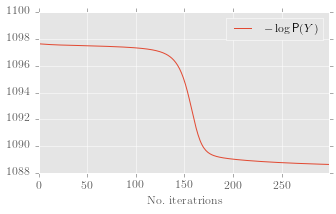

In [163]:
ax = h.plot()
ax.legend()
plt.xlabel('No. iteratrions')
ax.figure.tight_layout(pad=0.1)
ax.figure.savefig('test-stamp-random.pdf')

#### Matrix diff

/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


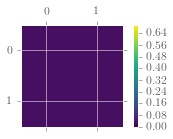

0.11610411050051161


/usr/lib/python3/dist-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


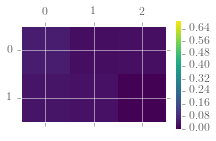

0.19149507900903606


In [204]:
plt.rcParams['figure.figsize'] = 2.9, 1.8   # 0.45

import colormaps as cmaps

for attr in ('A', 'B'):
    fig, ax = plt.subplots()
    diff = (getattr(hmm_train, attr) - getattr(hmm_reference, attr)).get_abs()
    cax = ax.matshow(diff, cmap=cmaps.viridis, vmin=0, vmax=max(getattr(hmm_reference, attr))[0])
#     plt.matshow(diff, fignum=100, cmap=cmaps.viridis, vmin=0, vmax=max(getattr(hmm_reference, attr))[0])
#     ax.set_title('blah')
    cbar = fig.colorbar(cax)
    plt.tight_layout(pad=0.2)
    plt.savefig('diff-%s.pdf' % attr)
    plt.show()
    print(diff.get_sum())
#     print(sum(diff))

# fig, axes = plt.subplots(nrows=1, ncols=2)
# attrs = ('A', 'B')
# for i in range(2):
#     diff = (getattr(hmm_train, attrs[i]) - getattr(hmm_reference, attrs[i])).get_abs()
#     im = axes.flat[i].matshow(diff, cmap=cmaps.viridis, vmin=0, vmax=max(getattr(hmm_reference, attr))[0])

# plt.tight_layout()
# fig.colorbar(im, ax=axes.ravel().tolist())


# plt.savefig('diff-together.pdf')
plt.show()

#### State probability matches

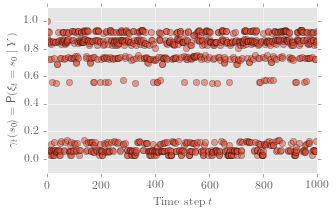

In [165]:
plt.rcParams['figure.figsize'] = 4.5, 2.8   # 0.7
plt.plot([hmm_train.mem['gamma'][t][hmm_train.S[0]] for t in range(T)], 'o', alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.xlabel('Time step $t$')
plt.ylabel(r'$\gamma_t(s_0) = \mathsf{P}(\xi_t = s_0 \mid Y)$')
plt.tight_layout(pad=0.1)
plt.savefig('state-dist.pdf')

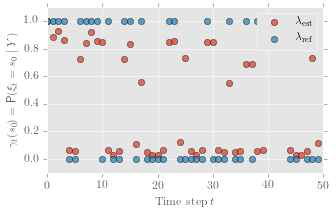

In [183]:
plt.plot([hmm_train.mem['gamma'][t][hmm_train.S[0]] for t in range(T)][:50], 'o', alpha=0.8, label=r'$\lambda_\mathrm{est}$')
plt.plot((np.array(X)[:50] == hmm_train.S[0]), 'o', alpha=0.8, label=r'$\lambda_\mathrm{ref}$')
plt.legend(numpoints=1)
plt.ylim(-0.1, 1.1)
plt.xlabel('Time step $t$')
plt.ylabel(r'$\gamma_t(s_0) = \mathsf{P}(\xi_t = s_0 \mid Y)$')
plt.tight_layout(pad=0.1)
plt.savefig('state-comp.pdf')

In [190]:
state_0_dist = [hmm_train.mem['gamma'][t][hmm_train.S[0]] for t in range(T)]
sum((np.array(X) == hmm_train.S[0]) ==
    (np.array(state_0_dist) > 0.5)) / T

0.80500000000000005

In [184]:
hmm_train.create_log_matrices()

In [188]:
sum(np.array(hmm_train.viterbi(Y)) == np.array(X)) / T

0.80500000000000005

### Marvin the Martian reads brown corpus

In [ ]:
import sys
# import resource
# resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
# sys.setrecursionlimit(10**6)

corpus_path = '/home/xio/Projects/СПбГУ/Курсовая-5/brown_corpus/'

Y = []

for fname in ['A01', 'A02', 'A03', 'A04', 'A05']:
    f = open(corpus_path + fname, 'r')
    for line in f:
        Y += [letter.lower() for letter in list(line[15:].strip())
                if letter.isalpha() or letter == ' ']
    f.close()

Y = Y[:50000]
print(Y[:10])

import string
Q = string.ascii_lowercase+' '
S = ['V', 'C']      # vowel, consonant

In [ ]:
priors = [0.51316, 0.48684]
A = [[0.47468, 0.52532],
     [0.51656, 0.48344]]

B = [[0.03735,0.03408,0.03455,0.03828,0.03782,0.03922,0.03688,0.03408,0.03875,0.04062,0.03735,0.03968,0.03548,0.03735,0.04062,0.03595,0.03641,0.03408,0.04062,0.03548,0.03922,0.04062,0.03455,0.03595,0.03408,0.03408,0.03688],
     [0.03909,0.03537,0.03537,0.03909,0.03583,0.03630,0.04048,0.03537,0.03816,0.03909,0.03490,0.03723,0.03537,0.03909,0.03397,0.03397,0.03816,0.03676,0.04048,0.03443,0.03537,0.03955,0.03816,0.03723,0.03769,0.03955,0.03397]]

hmm_marvin = HMM(S, Q, priors, A, B)

VERBOSITY = 4

# print("Initialized this HMM: ")
# print(hmm_marvin)

In [ ]:
print("Training the model:")
%time h = hmm_marvin.baum_welch_step(Y)

In [ ]:
# for metric in ['P(Y)', 'model']:
#     hmm_marvin = HMM(S, Q, priors, A, B)
#     h = hmm_marvin.train(Y, metric=metric, max_iter=100)
#     h.plot()
hmm_marvin = HMM(S, Q, priors, A, B)
h = hmm_marvin.train(Y, metric='P(Y)', max_iter=100)
h.plot()

In [ ]:
df = pd.DataFrame(list(zip(*hmm_marvin.B)), columns=['V', 'C'], index=list(hmm_marvin.Q))
ax = df.plot(kind='bar', stacked=True, figsize=(10, 8), fontsize=16)
ax.tick_params(labelsize=14)

In [ ]:
ax.get_figure().savefig('a.svg')

In [ ]:
''.join(hmm_marvin.simulate(100)[1])

In [ ]:
s1 = ''.join(hmm_marvin.simulate(100)[1])
s2 = ''.join(hmm_marvin.simulate(100)[1])
print('%f, %f' % (math.log(hmm_marvin.pr_Y(s1)), math.log(hmm_marvin.pr_Y(s2))))

In [ ]:
random_s = ''.join(np.random.choice(list(string.ascii_lowercase + ' '), size=100))
math.log(hmm_marvin.pr_Y(random_s))

### Marvin the Martian reads Russian news

In [167]:
import sys
# import resource
# resource.setrlimit(resource.RLIMIT_STACK, (2**29,-1))
# sys.setrecursionlimit(10**6)

corpus_path = '/home/xio/Projects/СПбГУ/Курсовая-5/ru_corpus/'

Q = 'абвгдежзийклмнопрстуфхцчшщъыьэюя '
S = ['C', 'V']      # vowel, consonant

Y = []
with open(corpus_path + 'news.2008.ru.shuffled', 'r') as f:
    if len(Y) < 5 * 10**4:
        for line in f:
            Y += [letter.lower() for letter in list(line.strip())
                  if letter.lower() in Q]
            Y += ' '

Y = Y[:50000]
''.join(Y[:100])

'без единой тенденции закрылись торги на европейских рынках акций в ходе инцидента был застрелен граж'

In [169]:
hmm_marvin_ru = HMM(S, Q)

VERBOSITY = 4

# print("Initialized this HMM: ")
# print(hmm_marvin_ru)

In [170]:
print("Training the model:")
%time h_ru = hmm_marvin_ru.baum_welch_step(Y)

Training the model:
CPU times: user 13.7 s, sys: 40 ms, total: 13.8 s
Wall time: 13.8 s


iter #0 inf
iter #1 22368.901525961497
iter #2 0.13830216496717185
iter #3 0.18456179922213778
iter #4 0.2531078083557077
iter #5 0.3547279993945267
iter #6 0.5064589176909067
iter #7 0.7355718142352998
iter #8 1.0863530835194979
iter #9 1.6317736594646703
iter #10 2.4938238840550184
iter #11 3.8794585969590116
iter #12 6.145266332809115
iter #13 9.916516106430208
iter #14 16.31303806460346
iter #15 27.394694011978572
iter #16 47.08021758164978
iter #17 83.12331115652341
iter #18 151.42407280983753
iter #19 284.71151560594444
iter #20 543.1648833995278
iter #21 985.365400046343
iter #22 1459.1219500960433
iter #23 1419.9526737254637
iter #24 845.5087573933997
iter #25 434.7962928850029
iter #26 275.80253926772275
iter #27 198.70184678558144
iter #28 148.136951168417
iter #29 112.39022649658727
iter #30 86.88414591387846
iter #31 68.75248200626811
iter #32 55.93405360728502
iter #33 46.88460652530193
iter #34 40.44636462070048
iter #35 35.76008347669267
iter #36 32.195465339842485
iter 

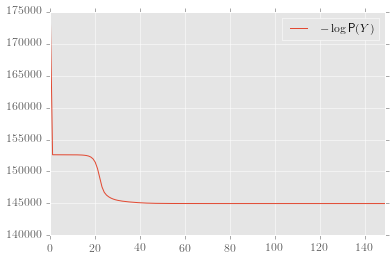

In [171]:
hmm_marvin_ru = HMM(S, Q)
h_ru = hmm_marvin_ru.train(Y, metric='P(Y)', eps=0.0001, max_iter=150)
h_ru.plot()

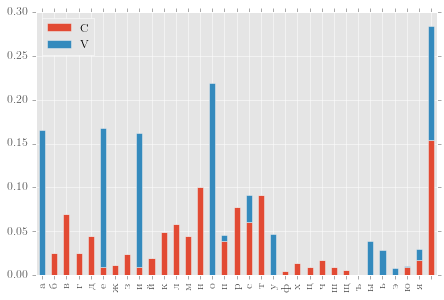

In [175]:
# df = pd.DataFrame(list(zip(*hmm_marvin_ru2.B)), columns=(hmm_marvin_ru2.S), index=list(hmm_marvin_ru2.Q))
df = pd.DataFrame(list(zip(*hmm_marvin_ru.B)), columns=(['C', 'V']), index=list(hmm_marvin_ru.Q))
ax = df.plot(kind='bar', stacked=True)
ax.figure.tight_layout(pad=0.1)
ax.figure.savefig('marvin_ru.pdf')

In [ ]:
''.join(hmm_marvin_ru.simulate(100)[1])